# XArray Example

To run this example, an environment.yml similar to this one could be used:

```yaml
name: bh_xhistogram
channels:
  - conda-forge
dependencies:
  - python==3.8
  - boost-histogram
  - xhistogram
  - matplotlib
  - netcdf4
```

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import boost_histogram as bh
from xhistogram.xarray import histogram as xhistogram

Let's look at using boost-histogram to imitate the xhistogram package by reading and producing xarrays. As a reminder, xarray is a sort of generalized Pandas library, supporting ND labeled and indexed data.

## Simple 1D example

We will start with the first example from the xhistogram docs:

In [2]:
da = xr.DataArray(np.random.randn(100, 30),
                  dims=['time', 'x'],
                  name='foo')
bins = np.linspace(-4, 4, 20)

#### xhistogram

And, this is what historamming and plotting looks like:

<xarray.DataArray 'histogram_foo' (foo_bin: 19)>
array([  2,   1,   2,  22,  56, 135, 234, 375, 453, 496, 456, 346, 226,
        96,  65,  25,   7,   3,   0])
Coordinates:
  * foo_bin  (foo_bin) float64 -3.789 -3.368 -2.947 -2.526 ... 2.947 3.368 3.789

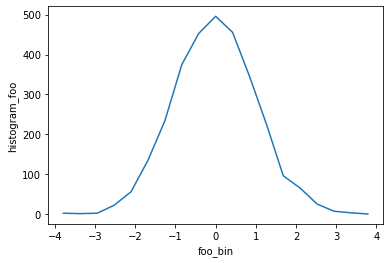

In [3]:
h = xhistogram(da, bins=[bins])
display(h)
h.plot(); # h is an xarray

#### boost-histogram (direct usage)

Let's first just try this by hand, to see how it works. This will not return an xarray, etc.

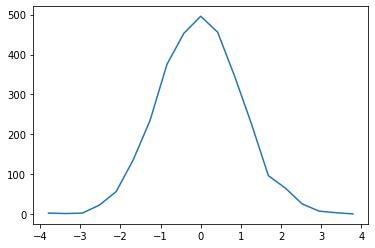

In [4]:
bh_bins = bh.axis.Regular(19, -4, 4)
bh_hist = bh.Histogram(bh_bins).fill(np.asarray(da).flatten())
plt.plot(bh_hist.axes[0].centers, bh_hist);

#### boost-histogram (adapter function)

Now, let's make an adaptor for boost-histogram.

In [5]:
def bh_xhistogram(*args, bins):
    
    # Convert bins to boost-histogram axes first
    prepare_bins = (bh.axis.Variable(b) for b in bins)
    h = bh.Histogram(*prepare_bins)
    
    # We need flat NP arrays for filling
    prepare_fill = (np.asarray(a).flatten() for a in args)
    h.fill(*prepare_fill)
    
    # Now compute the xarray output.
    return xr.DataArray(h,
            name="_".join(a.name for a in args) + "_histogram",
            coords=[(f"{a.name}_bin", arr.flatten(), a.attrs)
                      for a, arr in zip(args, h.axes.centers)])

<xarray.DataArray 'foo_histogram' (foo_bin: 19)>
array([  2.,   1.,   2.,  22.,  56., 135., 234., 375., 453., 496., 456.,
       346., 226.,  96.,  65.,  25.,   7.,   3.,   0.])
Coordinates:
  * foo_bin  (foo_bin) float64 -3.789 -3.368 -2.947 -2.526 ... 2.947 3.368 3.789

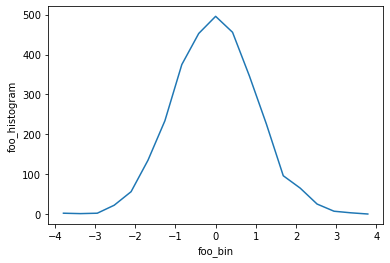

In [6]:
h = bh_xhistogram(da, bins=[bins])
display(h)
h.plot();

### More features

Let's add a few more features to our function defined above.
* Let's allow bins to be a list of axes or even a completly prepared histogram; this will allow us to take advantage of boost-histogram features later.
* Let's add a weights keyword so we can do weighted histograms as well.

In [7]:
def bh_xhistogram(*args, bins, weights=None):
    """
    bins is either a histogram, a list of axes, or a list of bins
    """
    
    if isinstance(bins, bh.Histogram):
        h = bins
    else:
        prepare_bins = (b if isinstance(b, bh.axis.Axis) else bh.axis.Variable(b) for b in bins)
        h = bh.Histogram(*prepare_bins)
    
    prepare_fill = (np.asarray(a).flatten() for a in args)
    
    if weights is None:
        h.fill(*prepare_fill)
    else:
        prepared_weights, *_ = xr.broadcast(weights, *args)
        h.fill(*prepare_fill, weight=np.asarray(prepared_weights).flatten())
    
    return xr.DataArray(h,
            name="_".join(a.name for a in args) + "_histogram",
            coords=[(f"{a.name}_bin", arr.flatten(), a.attrs)
                      for a, arr in zip(args, h.axes.centers)])

## 2D example

This also comes from the xhistogram docs.

In [8]:
# Read WOA using opendap
Temp_url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA13/5_deg/annual/temp'
Salt_url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA13/5_deg/annual/salt'
Oxy_url = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA13/5_deg/annual/doxy'

ds = xr.merge([
    xr.open_dataset(Temp_url).tmn.load(),
    xr.open_dataset(Salt_url).smn.load(),
    xr.open_dataset(Oxy_url).omn.load()])

In [9]:
sbins = np.arange(31,38, 0.025)
tbins = np.arange(-2, 32, 0.1)

#### xhistogram

/usr/local/Caskroom/miniconda/base/envs/xtest/lib/python3.8/site-packages/xarray/core/computation.py:601: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


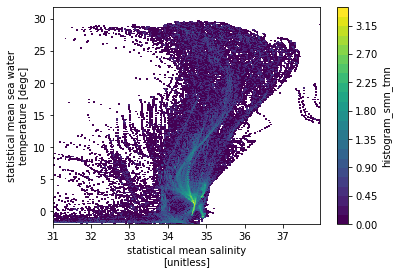

In [10]:
hTS = xhistogram(ds.smn, ds.tmn, bins=[sbins, tbins])
np.log10(hTS.T).plot(levels=31)

#### boost-histogram

We could hand in the same bin definitions, but let's use boost-histogram axes instead:

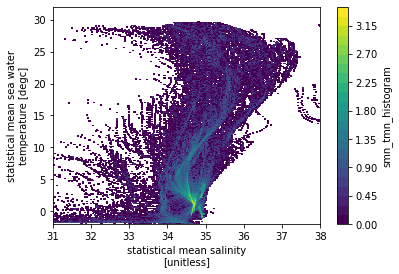

In [11]:
sax = bh.axis.Regular(250, 31, 38)
tax = bh.axis.Regular(340, -2, 32)

hTS = bh_xhistogram(ds.smn, ds.tmn, bins=[sax, tax])
np.log10(hTS.T).plot(levels=31)

### Speed comparson

In [12]:
%%timeit
hTS = xhistogram(ds.smn, ds.tmn, bins=[sbins, tbins])

17.6 ms ± 508 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
%%timeit
hTS = bh_xhistogram(ds.smn, ds.tmn, bins=[sax, tax])

4.7 ms ± 245 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Weighted histogram

Let's try a more complex example from the docs; the dVol weights one:

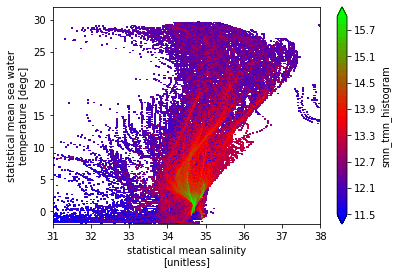

In [14]:
dz = np.diff(ds.lev)
dz =np.insert(dz, 0, dz[0])
dz = xr.DataArray(dz, coords= {'lev':ds.lev}, dims='lev')

dVol = dz * (5*110e3) * (5*110e3*np.cos(ds.lat*np.pi/180))

hTSw = bh_xhistogram(ds.smn, ds.tmn, bins=[sax, tax], weights=dVol)
np.log10(hTSw.T).plot(levels=31, vmin=11.5, vmax=16, cmap='brg')